In [1]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

import sys; sys.path.insert(1, '/home/alessandro/thesis_material/EURECA_scripts')
import os

import geometry as gm
#import conversion as cnv
from func_statistics import compute_pdf_nbin, slopes_r_p, slopes_r_p_onlysub, slopes_r_p_mix, slope_time, slope_maps
import regression
#from coare_functions import *
import meteo
import lcl
import metpy.calc as mpcalc
from metpy.units import units


import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background
from plotdistr import * #fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d
from pdist_fb_distrib_save_fast import *

import warnings; warnings.filterwarnings("ignore")


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# read  data
path_data = '/saturn/simu_Caribbean/forced_3km/CNT/FEB/01/'
wrf_files = path_data + 'wrfout_d02_2020-0'
fname_list = sorted(glob.glob(wrf_files + '*'))
ds = xr.open_mfdataset(fname_list, concat_dim='Time', combine='nested')

In [4]:
minlon = -60.; maxlon = -51.
minlat = 0.; maxlat = 17.

# select domain
mask_lon = (ds.XLONG >= minlon) & (ds.XLONG <= maxlon)
mask_lat = (ds.XLAT >= minlat) & (ds.XLAT <= maxlat)
ds = ds.where(mask_lon & mask_lat, drop=True)

In [5]:
# def lon lat time
lon = ds['XLONG'][0].values
lat = ds['XLAT'][0].values
time = ds['XTIME'].values.astype('<M8[s]')
# land - sea mask
lakemask = ds['LAKEMASK'][0].values
landmask = ds['LANDMASK'][0].values
seamask = 1 - lakemask - landmask
seamask[seamask==0] = np.nan
# def extended land-sea mask
seamask_nocoast = seamask.copy(); seamask_island0 = seamask.copy()
seamask_island0[:int(seamask_island0.shape[0]/2),:] = 1
seamask_island = seamask_island0.copy()
for i in range(0,5):
    for j in range(0,5):
        seamask_nocoast = np.roll(seamask, (i,j), axis=(1,0))*seamask_nocoast
        seamask_island = np.roll(seamask_island0, (-i,-j), axis=(1,0))*seamask_island
seamask_nocoast = seamask_nocoast*seamask_island
seamask = seamask_nocoast.copy()
del seamask_nocoast, lakemask, landmask

In [35]:
sst_day = ds['SST'].groupby('XTIME.day').mean().values*seamask
T2_day = ds['T2'].groupby('XTIME.day').mean().values*seamask # K

In [9]:
 # dSST vs T2
perc_step = 5
popmean=0
nbins = int(100/perc_step) # Number of bins.

pdist_sst, pdist_T2, pstd_T2, pstderr_T2, pnpoints_T2, ppvalue_T2 = distrib_2d(sst_day, T2_day, perc_step, nbins, popmean, perc_fixbin='perc')

In [33]:
q2_day = ds['Q2'].groupby('XTIME.day').mean().values*seamask*1e3

In [34]:
perc_step = 5
popmean = 0
nbins = int(100/perc_step) # Number of bins.

pdist_sst, pdist_q2, pstd_q2, pstderr_q2, pnpoints_q2, ppvalue_q2 = distrib_2d(sst_day, q2_day, perc_step, nbins, popmean, perc_fixbin='perc')

### let's have a quick look at QVAPOR

In [6]:
# load data
QVAPOR = ds['QVAPOR'].groupby('XTIME.day').mean()*seamask
QVAPOR = QVAPOR.transpose('bottom_top', 'day', 'south_north', 'west_east')

In [43]:
### LOAD PRESSURE COLUMN
mean_vert_pres = np.load('/venus/tesi_ale/data_EU_forced/P/mean_vert_pres_forced.npy')

In [44]:
sst_1 = np.nanpercentile(sst_day, 1)
sst_20 = np.nanpercentile(sst_day, 20)
sst_80 = np.nanpercentile(sst_day, 80)
sst_95 = np.nanpercentile(sst_day, 95)

mask_1  = sst_day<sst_1;  mask_1 = np.where(mask_1, 1, np.nan)
mask_20 = sst_day<sst_20; mask_20 = np.where(mask_20, 1, np.nan)
mask_80 = sst_day>sst_80; mask_80 = np.where(mask_80, 1, np.nan)
mask_95 = sst_day>sst_95; mask_95 = np.where(mask_95, 1, np.nan)
mask_between = (sst_day>sst_20) & (sst_day<sst_80)
mask_between = np.where(mask_between, 1, np.nan)

# masks = [mask_1, mask_20, mask_between, mask_80, mask_95]
# labs_leg = ['1st perc', '20th perc', '80th perc', '95th perc']

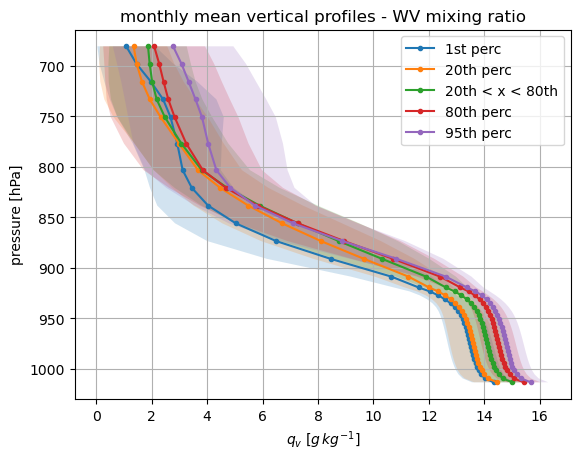

In [45]:
fig, ax = plt.subplots(1)
ax.invert_yaxis()

lev = int(38)
### ADD THE PBLH WITH THE MASKS

masks = [mask_1, mask_20, mask_between, mask_80, mask_95]
labs_leg = ['1st perc', '20th perc', '20th < x < 80th', '80th perc', '95th perc']

for i in range(5):

    qvap_p = QVAPOR.values*masks[i]*1000
    qvap_std = np.nanstd(qvap_p, axis=(1,2,3))
    qvap_profile = np.nanmean(qvap_p, axis=(1,2,3))
    
    ax.plot(qvap_profile[0:lev], mean_vert_pres[0:lev], '.-', label=labs_leg[i])
    ax.fill_betweenx(mean_vert_pres[0:lev], qvap_profile[0:lev]+qvap_std[0:lev], qvap_profile[0:lev]-qvap_std[0:lev],\
                     alpha=0.2)
    
    
ax.legend(loc='upper right')
ax.set_title(r'monthly mean vertical profiles - WV mixing ratio')
ax.set_xlabel(r'$q_v$ [$g\,kg^{-1}$]')
ax.set_ylabel('pressure [hPa]')
ax.grid()

### compute an integrated value of moisture

In [14]:
PBLH_day = ds['PBLH'].groupby('XTIME.day').mean().values*seamask
PBLH_pres = mpcalc.height_to_pressure_std(PBLH_day*units.meters)
PBLH_pres = PBLH_pres.magnitude #.m_as('hPa')

In [8]:
GPH_base = ds['PHB']/9.81  
GPH = ds['PH']/9.81 

GPH = GPH_base + GPH
GPH = GPH.groupby('XTIME.day').mean()*seamask
GPH = GPH.transpose('bottom_top_stag', 'day', 'south_north', 'west_east')
del GPH_base

In [9]:
press_from_GPH = mpcalc.height_to_pressure_std(GPH.values*units.meters)
del GPH

In [11]:
press_diff = np.zeros_like(QVAPOR.values)
press_diff = press_from_GPH[0:-1,:,:,:] - press_from_GPH[1:,:,:,:] 
# del press_from_GPH

In [ ]:
'''press_diff = xr.DataArray(press_diff, name='press_diff', dims=['Time', 'bottom_top', 'south_north', 'west_east'])
press_diff.attrs['long name'] = 'pressure difference up to 30th GPH level, forced simulation'
press_diff.attrs['units'] = 'metres [m]'

press_diff.to_netcdf('/venus/tesi_ale/data_EU/FORCED_GPH/press_diff_forced.nc')'''

In [16]:
'''LWP_mabl = (QVAPOR*press_diff.magnitude).where(press_from_GPH.magnitude[0:-1] >= PBLH_pres).sum(dim='bottom_top')'''

In [20]:
mask = press_from_GPH.magnitude[:-1] >= PBLH_pres
LWP_mabl_np = np.sum((QVAPOR.values * press_diff.magnitude) * mask, axis=0)
thickness_mabl = press_from_GPH[0].magnitude - PBLH_pres

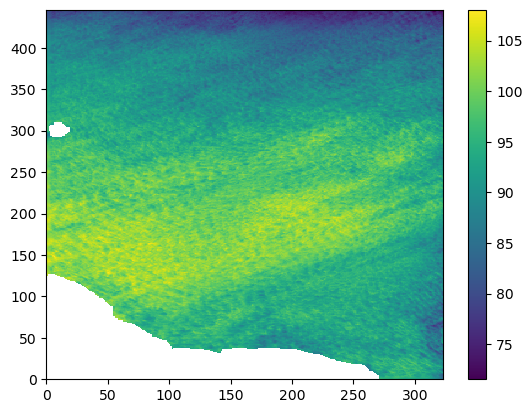

In [25]:
plt.pcolormesh(thickness_mabl[0])
plt.colorbar()

In [26]:
'''LWP_malb = LWP_mabl/thickness_mabl'''
LWP_mabl_np = LWP_mabl_np/thickness_mabl

In [30]:
LWP_mabl_ar = xr.DataArray(LWP_mabl_np, name='LWP_mabl', dims=['day', 'south_north', 'west_east'])
LWP_mabl_ar.attrs['long name'] = 'mean integrated MABL moisture (LWP)'
LWP_mabl_ar.attrs['units'] = 'kg / kg'

LWP_mabl_ar.to_netcdf('/venus/tesi_ale/data_bulk/sensitivities/LWP_mabl_rifatto_forced.nc')

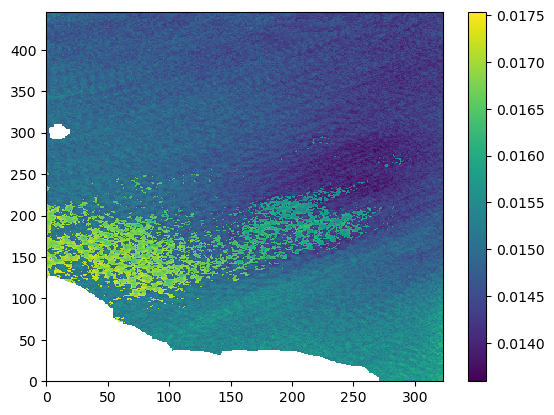

In [32]:
plt.pcolormesh(LWP_mabl_np[0])
plt.colorbar()

## this part is fully dedicated to linking the bulk to simulation

### bulk sensitivities are here:
### /venus/tesi_ale/data_bulk/sensitivities/SST_sens_VaryingQFree_ .... .pickle

In [33]:
LWP_mabl = xr.open_dataset('/venus/tesi_ale/data_bulk/sensitivities/LWP_mabl_forced.nc')

In [38]:
import pickle 
## choose between
## SST_sens_VaryingQFree_REFpSFCp.pickle
## SST_sens_VaryingQFree_TODOAGAIN.pickle

filename = '/venus/tesi_ale/data_bulk/sensitivities/SST_sens_VaryingQFree_REFpSFCp.pickle'

with open(filename, 'rb') as handle:
    dict_bulk = pickle.load(handle)

with open('/venus/tesi_ale/data_bulk/sensitivities/SST_sens_VaryingQFree_REFpSFCp_FORCED.pickle', 'rb') as handle:
    dict_bulk_forced = pickle.load(handle)
    
print(dict_bulk.keys())
dict_bulk_forced.keys()

dict_keys(['0.004', '0.007', '0.01'])


dict_keys(['SST values', '0.004', '0.007', '0.01'])

In [40]:
SST_forced = dict_bulk_forced['SST values']
dict_bulk_forced.pop('SST values')

array([298.69082642, 298.99957275, 299.17059326, 299.30218506,
       299.41305542, 299.50689697, 299.59078979, 299.66952515,
       299.74584961, 299.81939697, 299.88983154, 299.95932007,
       300.0274353 , 300.09402466, 300.16131592, 300.23284912,
       300.31008911, 300.39743042, 300.51516724, 300.79766846])

In [36]:
 # dSST vs LWP
perc_step = 5
popmean=0
nbins = int(100/perc_step) # Number of bins.

pdist_sst, pdist_LWP, pstd_LWP, pstderr_LWP, pnpoints_LWP, ppvalue_LWP = distrib_2d(sst_day, LWP_mabl['LWP_mabl'].values, perc_step, nbins, popmean, perc_fixbin='perc')

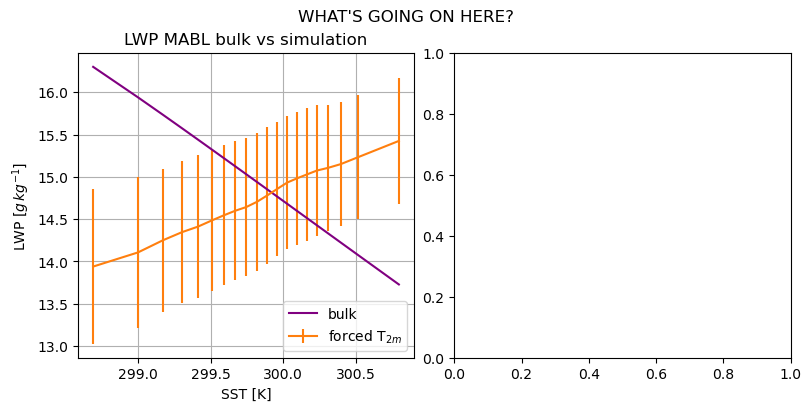

In [41]:
fig, ax = plt.subplots(1,2, figsize=(8,4), constrained_layout=True)
# fig.suptitle('Equilibrium variables VS '+param_of_interest+' ['+str_units+'] ,' + r'varying $q_{free}$' ,fontsize=16) #, E frac {E_frac}
fig.suptitle("WHAT'S GOING ON HERE?")


moist='0.004'

ax[0].errorbar(pdist_sst, pdist_LWP*1e3, yerr=pstd_LWP*1e3, xerr=None,\
             label=r'forced LWP', ecolor='#ff7f0e', linestyle='-', color='#ff7f0e')

ax[0].plot(SST_forced, dict_bulk_forced[moist]['q_eq']*1e3,  '-', color='purple', label = 'bulk')

ax[0].legend(loc='lower right')
ax[0].set_ylabel(r'LWP [$g\,kg^{-1}$]')
ax[0].set_xlabel('SST [K]')
ax[0].set_title(r"LWP MABL bulk vs simulation")
ax[0].grid()

No handles with labels found to put in legend.


/venus/tesi_ale/img_bulk/sensitivities/SST_sens_FullNS_varying_Qfree_SSTForced.pdf


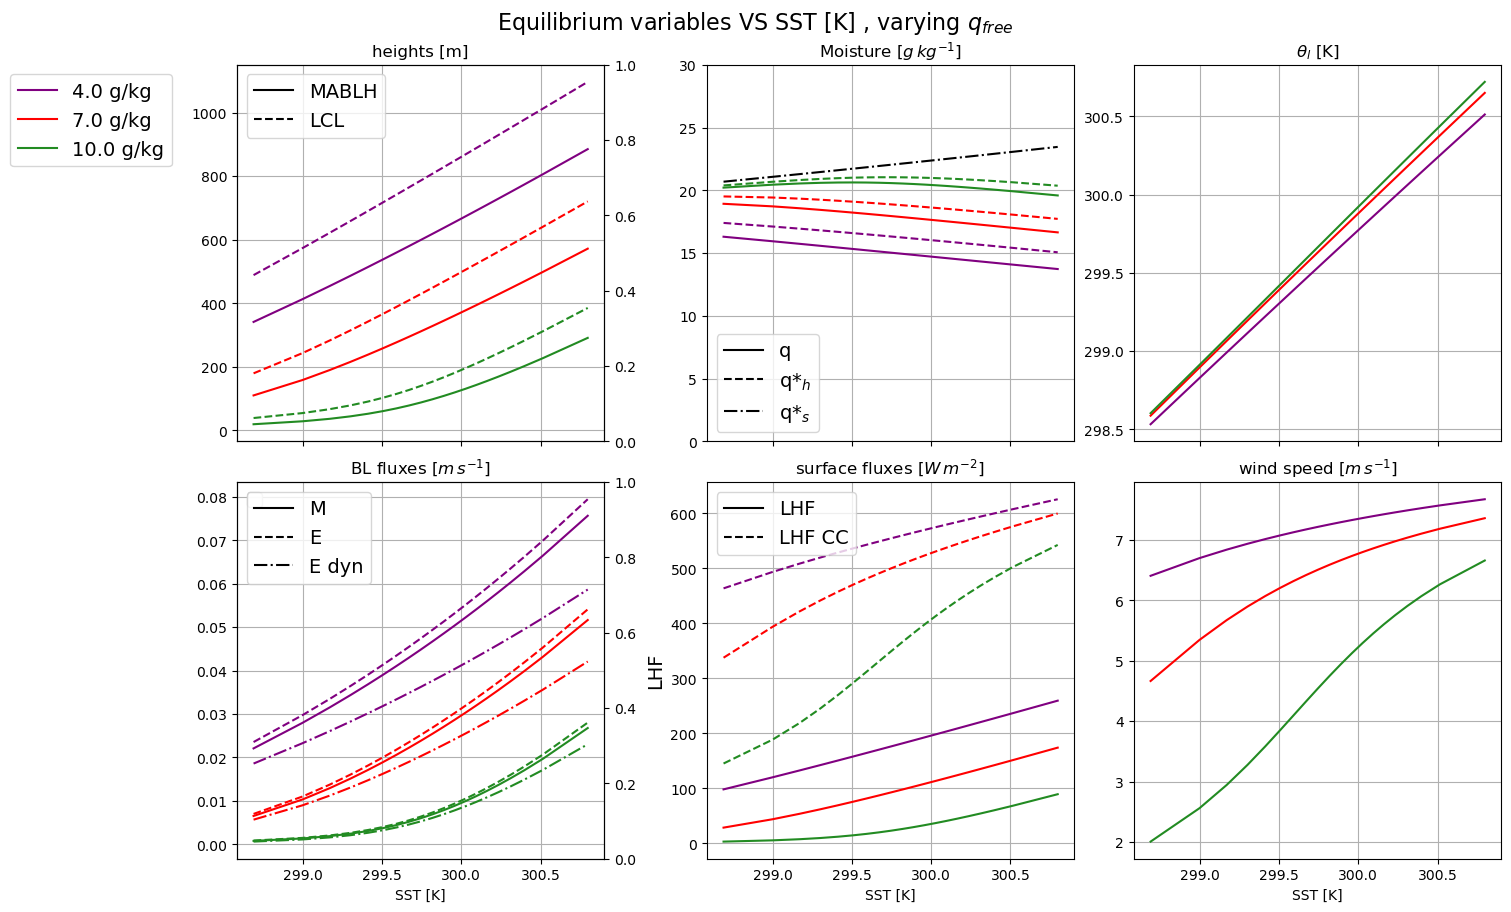

In [40]:
sys.path.append('/home/alessandro/thesis_material/EURECA_scripts/ABL_BULK/')
import neggers_stevens
import matplotlib.lines as mlines
#################################################################################################



param_of_interest = 'SST'; str_units = 'K'; label_model = 'Full'

colors = ['purple', 'red', 'forestgreen']
legend_entries = [ str(float(x)*1e3) for x in dict_bulk_forced.keys()]

fig, ax = plt.subplots(2,3,figsize=(15,9),sharex=True,constrained_layout=True)
# fig.suptitle('Equilibrium variables VS '+param_of_interest+' ['+str_units+']'+f' model {label_model}',fontsize=16) #, E frac {E_frac}
fig.suptitle('Equilibrium variables VS '+param_of_interest+' ['+str_units+'] ,' + r' varying $q_{free}$' ,fontsize=16) #, E frac {E_frac}



#########  h and LCL  ###########
solid_line = mlines.Line2D([], [], color='k', label='MABLH', linestyle='-')
dashed_line = mlines.Line2D([], [], color='k', label='LCL', linestyle='--')
ax[0,0].set_title('heights [m]')
ax[0,0].grid()

for i, moist in enumerate(dict_bulk_forced.keys()):
    ax[0,0].plot(SST_forced, dict_bulk_forced[moist]['h_eq'], '-', color=colors[i], label=legend_entries[i]+' g/kg')
    ax[0,0].plot(SST_forced, dict_bulk_forced[moist]['LCL_eq'], '--', color=colors[i])

ax[0,0].legend(fontsize=14, bbox_to_anchor=(-0.15, 1))
finto = ax[0,0].twinx()
finto.legend(handles=[solid_line, dashed_line], loc='upper left', fontsize=14)


#########  moisture  ##########
solid_line = mlines.Line2D([], [], color='k', label='q', linestyle='-')
dashed_line = mlines.Line2D([], [], color='k', label='q*$_h$', linestyle='--')
ax[0,1].set_title(r'Moisture [$g\,kg^{-1}$]')
ax[0,1].grid()
ax[0,1].set_ylim(0,30)

q_star = ax[0,1].plot(SST_forced, neggers_stevens.qsea(SST_forced-273.15,1000), '-.k', label='q*$_s$')

for i, moist in enumerate(dict_bulk_forced.keys()):
    ax[0,1].plot(SST_forced, dict_bulk_forced[moist]['q_eq'] * 1e3, '-', color=colors[i])
    ax[0,1].plot(SST_forced, dict_bulk_forced[moist]['qsat_eq'] * 1e3, '--', color=colors[i])

ax[0,1].legend(fontsize=14)
ax[0,1].legend(handles=[solid_line, dashed_line, q_star[0]], loc='lower left',  fontsize=14)




#######  temperature  ########
ax[0,2].set_title(r'$\theta_l$ [K]')
ax[0,2].grid()

for i, moist in enumerate(dict_bulk_forced.keys()):
    ax[0,2].plot(SST_forced, dict_bulk_forced[moist]['th_eq'],  '-', color=colors[i],)

    
    
    
    

######  entrainment M and E ######
solid_line = mlines.Line2D([], [], color='k', label='M', linestyle='-')
dashed_line = mlines.Line2D([], [], color='k', label='E', linestyle='--')
dashdot_line = mlines.Line2D([], [], color='k', label='E dyn', linestyle='-.')
ax[1,0].set_title(r'BL fluxes [$m\,s^{-1}$]')
ax[1,0].grid()

for i, moist in enumerate(dict_bulk_forced.keys()):
    ax[1,0].plot(SST_forced, dict_bulk_forced[moist]['M_eq'],  '-', color=colors[i])
    ax[1,0].plot(SST_forced, dict_bulk_forced[moist]['E_eq'],  '--', color=colors[i])
    ax[1,0].plot(SST_forced, dict_bulk_forced[moist]['we_dyn_eq'],  '-.', color=colors[i])

ax[1,0].legend(fontsize=14)
finto = ax[1,0].twinx()
finto.legend(handles=[solid_line, dashed_line, dashdot_line], loc='upper left', fontsize=14)




# ##############  HEAT FLUXES  ################
solid_line = mlines.Line2D([], [], color='k', label='LHF', linestyle='-')
dashed_line = mlines.Line2D([], [], color='k', label='LHF CC', linestyle='--')
# dashdot_line = mlines.Line2D([], [], color='k', label='SHF', linestyle=':')
ax[1,1].set_title(r'surface fluxes [$W\,m^{-2}$] ')
ax[1,1].grid()
# twinni = ax[1,1].twinx()
ax[1,1].set_ylabel('LHF', fontsize=14)
# twinni.set_ylabel(r'SHF', fontsize=14)

for i, moist in enumerate(dict_bulk_forced.keys()):
    ax[1,1].plot(SST_forced, dict_bulk_forced[moist]['LHF_eq'],  '-', color=colors[i])
    ax[1,1].plot(SST_forced, dict_bulk_forced[moist]['LHF_CC_eq'],  '--', color=colors[i])
#     twinni.plot(SST_forced, dict_bulk_forced[moist]['SHF_eq'], ':', color=colors[i])

# lines_labels = ax[1,1].get_lines() + twinni.get_lines()  # Combine lines from both axes
# labels = ['LHF', 'LHF_CC', 'SHF']  # Custom labels for the combined legend
# ax[1,1].legend(lines_labels, labels, fontsize=14)
# finto = ax[1,1].twinx()
ax[1,1].legend(handles=[solid_line, dashed_line], loc='upper left', fontsize=14)



##### wind #####
# solid_line = mlines.Line2D([], [], color='k', label='U', linestyle='-')
# dashdot_line = mlines.Line2D([], [], color='k', label='V', linestyle='-.')
# ax[1,2].set_title(r'wind [$m\,s^{-1}$]')
# ax[1,2].set_ylabel('U', fontsize=14)
# ax[1,2].grid()
# axx = ax[1,2].twinx()
# axx.set_ylabel('V', fontsize=14)

# for i, moist in enumerate(dict_bulk_forced.keys()):
#     ax[1,2].plot(SST_forced, dict_bulk_forced[moist]['U_eq'],  '-',color=colors[i], label='U')
#     axx.plot(SST_forced, dict_bulk_forced[moist]['V_eq'],  '-.',color=colors[i], label='V')

# axx.legend(handles=[solid_line, dashdot_line], loc='upper right', fontsize=14)

ax[1,2].set_title(r'wind speed [$m\,s^{-1}$]')
# ax[1,2].set_ylabel('U', fontsize=14)
ax[1,2].grid()
# axx = ax[1,2].twinx()
# axx.set_ylabel('V', fontsize=14)

for i, moist in enumerate(dict_bulk_forced.keys()):
    ax[1,2].plot(SST_forced, np.sqrt(dict_bulk_forced[moist]['U_eq']**2 +  dict_bulk_forced[moist]['V_eq']**2),  '-',color=colors[i], label='U')

# axx.legend(handles=[solid_line, dashdot_line], loc='upper right', fontsize=14)


###########################################à

for i in range(3):
    ax[1,i].set_xlabel('SST [K]')

base_path = '/venus/tesi_ale/img_bulk/sensitivities/'+param_of_interest+'_sens_'
filename = base_path + 'FullNS' #if box_model_bool else base_path+'Full'
filename = filename + '_varying_Qfree_SSTForced.pdf'
print(filename)
# plt.savefig(filename)



Text(0.5, 1.0, '$q_{2m}$ bulk vs simulation')

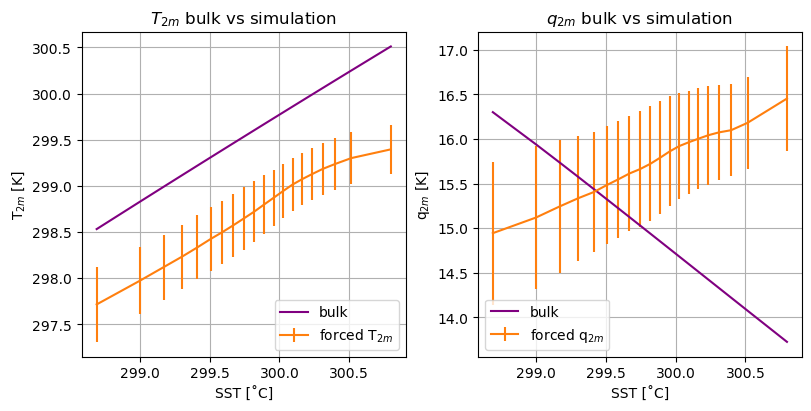

In [38]:
moist = '0.004'


fig, ax = plt.subplots(1,2,figsize=(8,4), constrained_layout=True)
# fig.suptitle('Equilibrium variables VS '+param_of_interest+' ['+str_units+'] ,' + r'varying $q_{free}$' ,fontsize=16) #, E frac {E_frac}


ax[0].errorbar(pdist_sst, pdist_T2, yerr=pstd_T2, xerr=None,\
             label=r'forced T$_{2m}$', ecolor='#ff7f0e', linestyle='-', color='#ff7f0e')

ax[0].plot(SST_forced, dict_bulk_forced[moist]['th_eq'],  '-', color='purple', label = 'bulk')

ax[0].legend(loc='lower right')
ax[0].set_ylabel(r'T$_{2m}$ [K]')
ax[0].set_xlabel('SST [˚C]')
ax[0].set_title(r"$T_{2m}$ bulk vs simulation")
ax[0].grid()



ax[1].errorbar(pdist_sst, pdist_q2, yerr=pstd_q2, xerr=None,\
             label=r'forced q$_{2m}$', ecolor='#ff7f0e', linestyle='-', color='#ff7f0e')

ax[1].plot(SST_forced, dict_bulk_forced[moist]['q_eq']*1e3,  '-', color='purple', label = 'bulk')

ax[1].legend(loc='lower left')
ax[1].set_ylabel(r'q$_{2m}$ [K]')
ax[1].set_xlabel('SST [˚C]')
ax[1].grid()
ax[1].set_title(r"$q_{2m}$ bulk vs simulation")

### visualize data

No handles with labels found to put in legend.


/venus/tesi_ale/img_bulk/sensitivities/SST_sens_FullNS_varying_Qfree_windSpeed.pdf


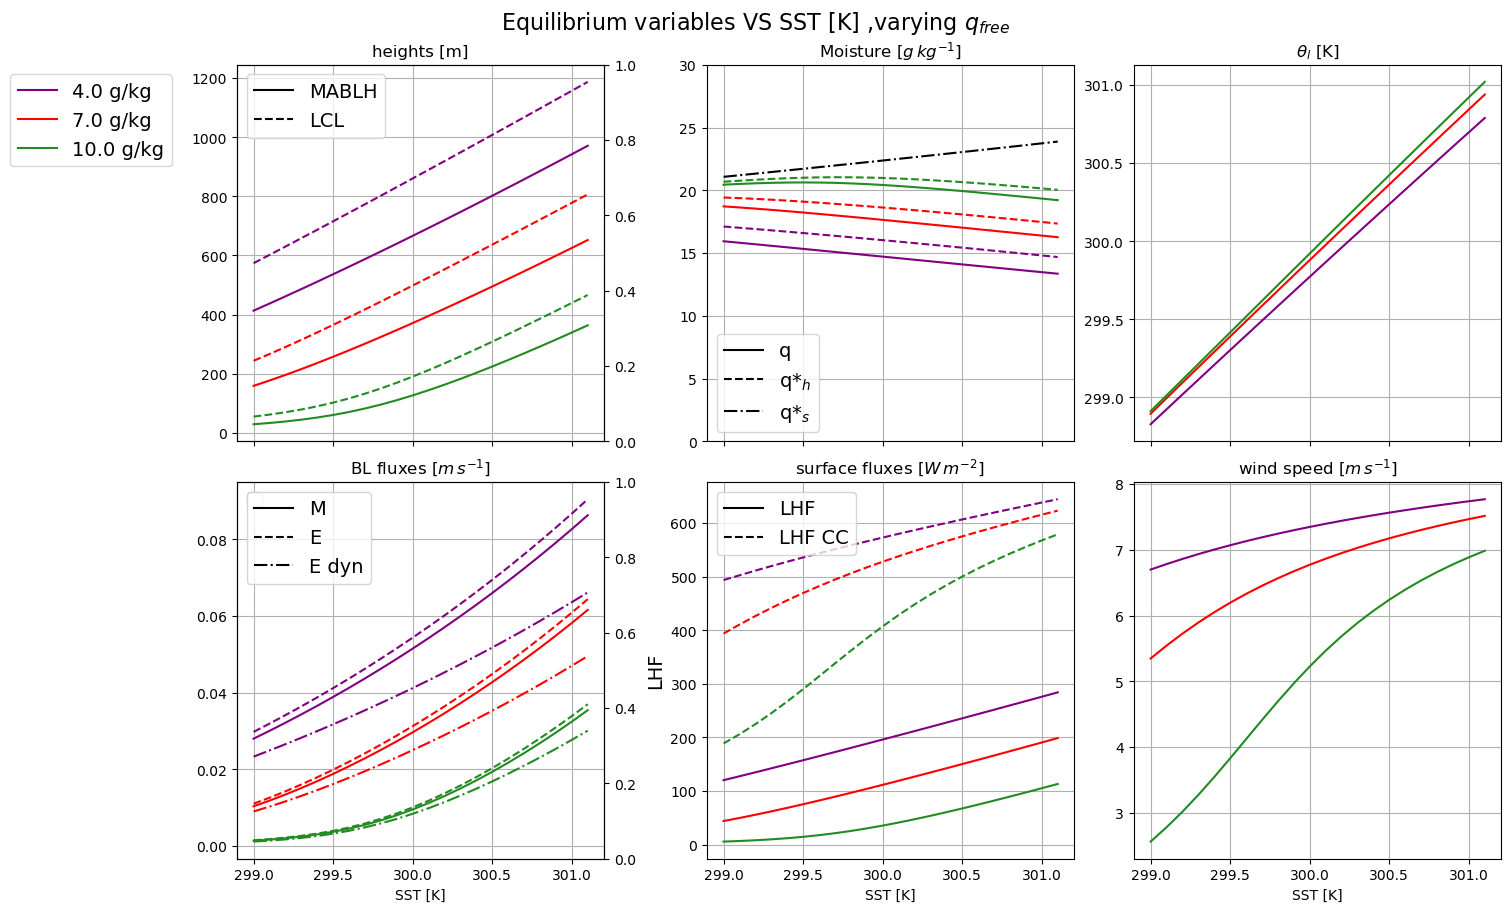

In [39]:
sys.path.append('/home/alessandro/thesis_material/EURECA_scripts/ABL_BULK/')
import neggers_stevens
import matplotlib.lines as mlines
#################################################################################################

param_of_interest = 'SST'; str_units = 'K'; label_model = 'Full'
SST_values = np.arange(299,301.1,0.1)

colors = ['purple', 'red', 'forestgreen']
legend_entries = [ str(float(x)*1e3) for x in dict_bulk.keys()]

fig, ax = plt.subplots(2,3,figsize=(15,9),sharex=True,constrained_layout=True)
# fig.suptitle('Equilibrium variables VS '+param_of_interest+' ['+str_units+']'+f' model {label_model}',fontsize=16) #, E frac {E_frac}
fig.suptitle('Equilibrium variables VS '+param_of_interest+' ['+str_units+'] ,' + r'varying $q_{free}$' ,fontsize=16) #, E frac {E_frac}



#########  h and LCL  ###########
solid_line = mlines.Line2D([], [], color='k', label='MABLH', linestyle='-')
dashed_line = mlines.Line2D([], [], color='k', label='LCL', linestyle='--')
ax[0,0].set_title('heights [m]')
ax[0,0].grid()

for i, moist in enumerate(dict_bulk.keys()):
    ax[0,0].plot(SST_values, dict_bulk[moist]['h_eq'], '-', color=colors[i], label=legend_entries[i]+' g/kg')
    ax[0,0].plot(SST_values, dict_bulk[moist]['LCL_eq'], '--', color=colors[i])

ax[0,0].legend(fontsize=14, bbox_to_anchor=(-0.15, 1))
finto = ax[0,0].twinx()
finto.legend(handles=[solid_line, dashed_line], loc='upper left', fontsize=14)


#########  moisture  ##########
solid_line = mlines.Line2D([], [], color='k', label='q', linestyle='-')
dashed_line = mlines.Line2D([], [], color='k', label='q*$_h$', linestyle='--')
ax[0,1].set_title(r'Moisture [$g\,kg^{-1}$]')
ax[0,1].grid()
ax[0,1].set_ylim(0,30)

q_star = ax[0,1].plot(SST_values, neggers_stevens.qsea(SST_values-273.15,1000), '-.k', label='q*$_s$')

for i, moist in enumerate(dict_bulk.keys()):
    ax[0,1].plot(SST_values, dict_bulk[moist]['q_eq'] * 1e3, '-', color=colors[i])
    ax[0,1].plot(SST_values, dict_bulk[moist]['qsat_eq'] * 1e3, '--', color=colors[i])

ax[0,1].legend(fontsize=14)
ax[0,1].legend(handles=[solid_line, dashed_line, q_star[0]], loc='lower left',  fontsize=14)




#######  temperature  ########
ax[0,2].set_title(r'$\theta_l$ [K]')
ax[0,2].grid()

for i, moist in enumerate(dict_bulk.keys()):
    ax[0,2].plot(SST_values, dict_bulk[moist]['th_eq'],  '-', color=colors[i],)

    
    
    
    

######  entrainment M and E ######
solid_line = mlines.Line2D([], [], color='k', label='M', linestyle='-')
dashed_line = mlines.Line2D([], [], color='k', label='E', linestyle='--')
dashdot_line = mlines.Line2D([], [], color='k', label='E dyn', linestyle='-.')
ax[1,0].set_title(r'BL fluxes [$m\,s^{-1}$]')
ax[1,0].grid()

for i, moist in enumerate(dict_bulk.keys()):
    ax[1,0].plot(SST_values, dict_bulk[moist]['M_eq'],  '-', color=colors[i])
    ax[1,0].plot(SST_values, dict_bulk[moist]['E_eq'],  '--', color=colors[i])
    ax[1,0].plot(SST_values, dict_bulk[moist]['we_dyn_eq'],  '-.', color=colors[i])

ax[1,0].legend(fontsize=14)
finto = ax[1,0].twinx()
finto.legend(handles=[solid_line, dashed_line, dashdot_line], loc='upper left', fontsize=14)




# ##############  HEAT FLUXES  ################
solid_line = mlines.Line2D([], [], color='k', label='LHF', linestyle='-')
dashed_line = mlines.Line2D([], [], color='k', label='LHF CC', linestyle='--')
# dashdot_line = mlines.Line2D([], [], color='k', label='SHF', linestyle=':')
ax[1,1].set_title(r'surface fluxes [$W\,m^{-2}$] ')
ax[1,1].grid()
# twinni = ax[1,1].twinx()
ax[1,1].set_ylabel('LHF', fontsize=14)
# twinni.set_ylabel(r'SHF', fontsize=14)

for i, moist in enumerate(dict_bulk.keys()):
    ax[1,1].plot(SST_values, dict_bulk[moist]['LHF_eq'],  '-', color=colors[i])
    ax[1,1].plot(SST_values, dict_bulk[moist]['LHF_CC_eq'],  '--', color=colors[i])
#     twinni.plot(SST_values, dict_bulk[moist]['SHF_eq'], ':', color=colors[i])

# lines_labels = ax[1,1].get_lines() + twinni.get_lines()  # Combine lines from both axes
# labels = ['LHF', 'LHF_CC', 'SHF']  # Custom labels for the combined legend
# ax[1,1].legend(lines_labels, labels, fontsize=14)
# finto = ax[1,1].twinx()
ax[1,1].legend(handles=[solid_line, dashed_line], loc='upper left', fontsize=14)



##### wind #####
# solid_line = mlines.Line2D([], [], color='k', label='U', linestyle='-')
# dashdot_line = mlines.Line2D([], [], color='k', label='V', linestyle='-.')
# ax[1,2].set_title(r'wind [$m\,s^{-1}$]')
# ax[1,2].set_ylabel('U', fontsize=14)
# ax[1,2].grid()
# axx = ax[1,2].twinx()
# axx.set_ylabel('V', fontsize=14)

# for i, moist in enumerate(dict_bulk.keys()):
#     ax[1,2].plot(SST_values, dict_bulk[moist]['U_eq'],  '-',color=colors[i], label='U')
#     axx.plot(SST_values, dict_bulk[moist]['V_eq'],  '-.',color=colors[i], label='V')

# axx.legend(handles=[solid_line, dashdot_line], loc='upper right', fontsize=14)

ax[1,2].set_title(r'wind speed [$m\,s^{-1}$]')
# ax[1,2].set_ylabel('U', fontsize=14)
ax[1,2].grid()
# axx = ax[1,2].twinx()
# axx.set_ylabel('V', fontsize=14)

for i, moist in enumerate(dict_bulk.keys()):
    ax[1,2].plot(SST_values, np.sqrt(dict_bulk[moist]['U_eq']**2 +  dict_bulk[moist]['V_eq']**2),  '-',color=colors[i], label='U')

# axx.legend(handles=[solid_line, dashdot_line], loc='upper right', fontsize=14)


###########################################à

for i in range(3):
    ax[1,i].set_xlabel('SST [K]')

base_path = '/venus/tesi_ale/img_bulk/sensitivities/'+param_of_interest+'_sens_'
filename = base_path + 'FullNS' #if box_model_bool else base_path+'Full'
filename = filename + '_varying_Qfree_windSpeed.pdf'
print(filename)
# plt.savefig(filename)



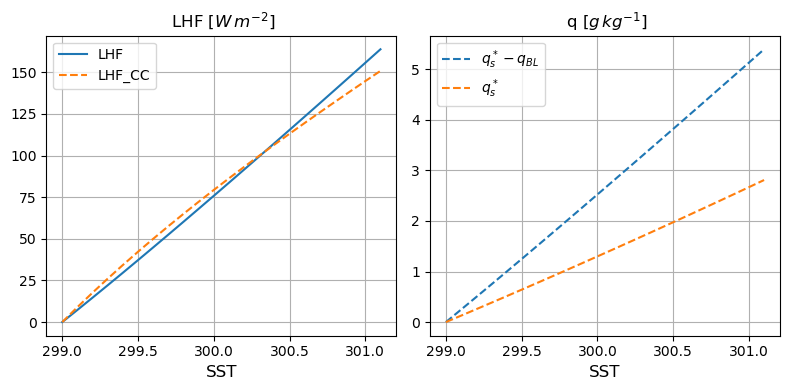

In [42]:
fig, ax = plt.subplots(1,2, figsize=(8,4))

ax[0].set_title(r' LHF [$W\,m^{-2}$] ')
ax[0].grid()
ax[0].set_xlabel('SST', fontsize=12)
moist = '0.004'


ax[0].plot(SST_values, dict_bulk[moist]['LHF_eq'] - np.nanmin(dict_bulk[moist]['LHF_eq']), '-', label='LHF')
ax[0].plot(SST_values, dict_bulk[moist]['LHF_CC_eq'] - np.nanmin(dict_bulk[moist]['LHF_CC_eq']), '--', label='LHF_CC')

# ax[0].plot(SST_values, dict_bulk[moist]['LHF_eq'], '-', label='LHF')
# ax[0].plot(SST_values, dict_bulk[moist]['LHF_CC_eq'] , '--', label='LHF_CC')
ax[0].legend()




moist_diff = (dict_bulk[moist]['qs_eq'] - dict_bulk[moist]['q_eq'])*1e3
moist_diff = (moist_diff - np.nanmin(moist_diff))
sat_moist = (dict_bulk[moist]['qs_eq'] - np.nanmin(dict_bulk[moist]['qs_eq']))*1e3
ax[1].grid()
ax[1].set_title(r' q [$g \, kg^{-1}$] ')
ax[1].set_xlabel('SST', fontsize=12)

ax[1].plot(SST_values, moist_diff, '--', label=r'$q^*_s - q_{BL}$')
ax[1].plot(SST_values, sat_moist, '--', label=r'$q^*_s$')
ax[1].legend()



# ###########   does rho contribute much?  ############

# cpd  = 1004.67                        # [J/K/kg], dry air specific heat at constant pressure
# Rd = 287.1
# ps = 1000.
# ref_p = ps

# T0 = dict_bulk[moist]['th_eq']*(ps/ref_p)**(Rd/cpd)
# # Surface air density.
# rhos = ps*100/(Rd*T0)

# ax[2].grid()
# ax[2].set_title(r' $\rho$ [$kg \, m^{-3}$] ')
# ax[2].set_xlabel('SST', fontsize=12)

# ax[2].plot(SST_values, rhos, '--', label=r'$q^*_s - q_{BL}$')
# # ax[2].legend()




plt.tight_layout()

In [61]:
### looking at derivatives
def compute_derivative(x, field):
    derivative = np.zeros_like(field)
    derivative[0]    = (field[1]-field[0])/(x[1]-x[0])
    derivative[1:-1] = (field[2:]-field[0:-2])/((x[2:]-x[0:-2]))
    derivative[-1]   = (field[-1]-field[-2])/(x[-1]-x[-2])
    return derivative

moist = '0.004'

dLHF_dSST = compute_derivative(SST_values, dict_bulk[moist]['LHF_eq'])
dLHFCC_dSST = compute_derivative(SST_values, dict_bulk[moist]['LHF_CC_eq'])

moist_diff = (dict_bulk[moist]['qs_eq'] - dict_bulk[moist]['q_eq'])*1e3
sat_moist = (dict_bulk[moist]['qs_eq'])*1e3

dqDiff_dSST = compute_derivative(SST_values, moist_diff)
dsat_moist  = compute_derivative(SST_values, sat_moist)





## wind derivative
dV_dSST = compute_derivative(SST_values, np.sqrt(dict_bulk[moist]['U_eq']**2 +  dict_bulk[moist]['V_eq']**2))

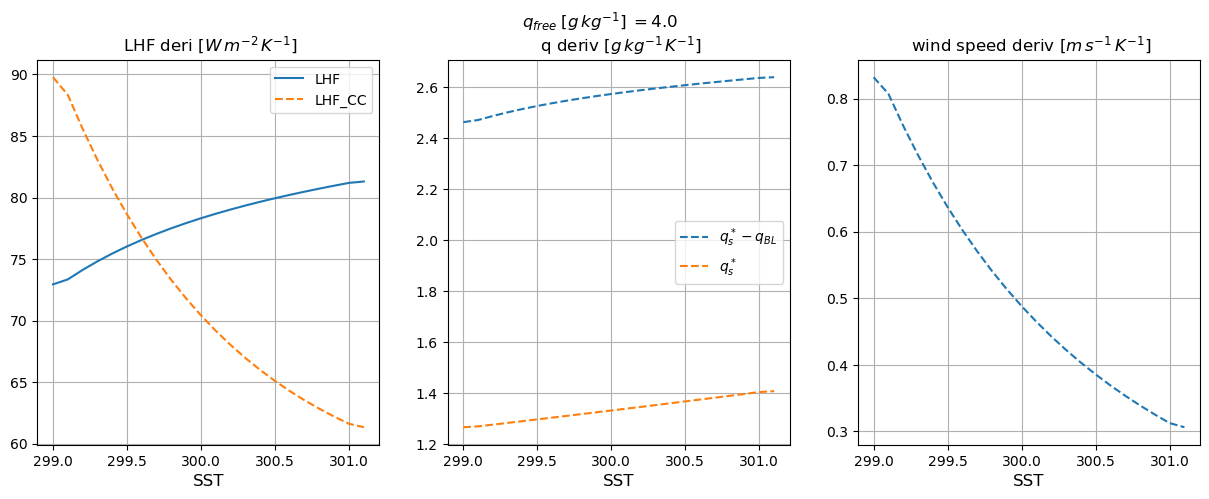

In [62]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
fig.suptitle(r'$q_{free} \; [g\,kg^{-1}] \; = $'+f'{float(moist)*1e3}')

ax[0].set_title(r' LHF deri [$W\,m^{-2}\, K^{-1}$] ')
ax[0].grid()
ax[0].set_xlabel('SST', fontsize=12)
ax[0].plot(SST_values, dLHF_dSST, '-', label='LHF')
ax[0].plot(SST_values, dLHFCC_dSST, '--', label='LHF_CC')
ax[0].legend()


ax[1].grid()
ax[1].set_title(r' q deriv [$g \, kg^{-1} \, K^{-1}$] ')
ax[1].set_xlabel('SST', fontsize=12)
ax[1].plot(SST_values, dqDiff_dSST, '--', label=r'$q^*_s - q_{BL}$')
ax[1].plot(SST_values, dsat_moist, '--', label=r'$q^*_s$')
ax[1].legend()


ax[2].grid()
ax[2].set_title(r' wind speed deriv [$m \, s^{-1} \, K^{-1}$] ')
ax[2].set_xlabel('SST', fontsize=12)
ax[2].plot(SST_values, dV_dSST, '--', label=r'$q^*_s - q_{BL}$')
# ax[2].legend()